# Feature detection

In this notebook we are going to have a detailed look at the feature detection of tobac and explore the parameters of the according function.

In [2]:
import tobac
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%matplotlib inline

## Minima/Maxima and multiple thresholds

When working different inputs it is sometimes necessary to switch the feature detection from finding maxima to minima. Furthermore, for more complex datasets containing multiple features differing in magnitude, a categorization according to this magnitude is desirable. Both will be demonstrated with the *make_sample_data_2D_3blobs()* function, which creates such a dataset. For the search for minima we will simply turn the dataset negative:

In [3]:
data = tobac.testing.make_sample_data_2D_3blobs()
neg_data = -data

Let us have a look at frame number 50:

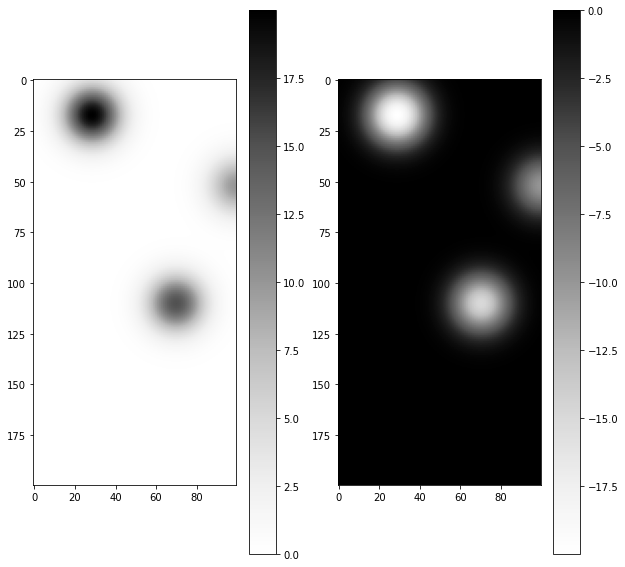

In [4]:
n = 50

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 10))

im1 = ax1.imshow(data.data[50], cmap = 'Greys')
cbar = plt.colorbar(im1, ax = ax1)

im2 = ax2.imshow(neg_data.data[50], cmap = 'Greys')
cbar = plt.colorbar(im2, ax = ax2)

As you can see the data has 3 maxima/minima with different extremal values. To capture these, we use list comprehensions to obtain multiple thresholds:

In [5]:
thresholds = [i for i in range(9, 18)]
inv_thresholds = [-i for i in range(9, 18)]

These can now be passed as arguments to *feature_detection_multithreshold()*. With the *target*-keyword we can set a flag whether to search for minima or maxima. The standard is *'maxima'*.

In [6]:
%%capture

dxy, dt = tobac.utils.get_spacings(data)

features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, thresholds, target = 'maximum')
features_inv = tobac.themes.tobac_v1.feature_detection_multithreshold(neg_data, dxy, inv_thresholds, target = 'minimum')

Let's scatter the found features onto frame 50 and create colorbars for threshold values:

Text(0, 0.5, 'threshold')

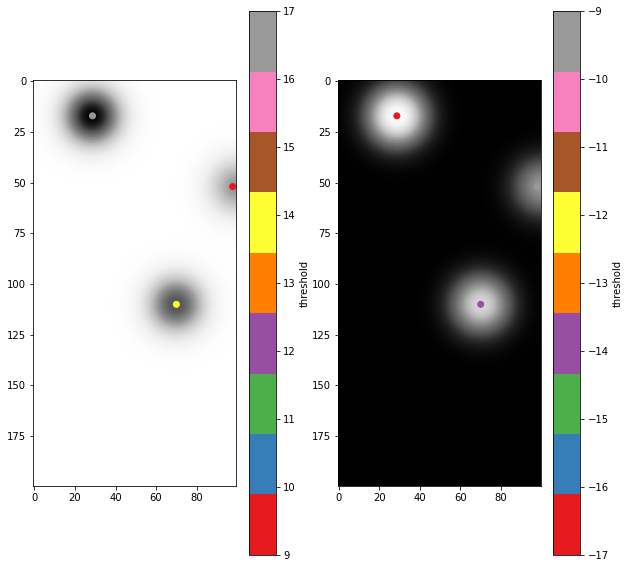

In [7]:
mask_1 = features['frame'] == n
mask_2 = features_inv['frame'] == n

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 10))

ax1.imshow(data.data[50], cmap = 'Greys')
im1 = ax1.scatter(features.where(mask_1)['hdim_2'], features.where(mask_1)['hdim_1'], c = features.where(mask_1)['threshold_value'], cmap = 'Set1')
cbar = plt.colorbar(im1, ax = ax1)
cbar.ax.set_ylabel('threshold')

ax2.imshow(neg_data.data[50], cmap = 'Greys')
im2 = ax2.scatter(features_inv.where(mask_2)['hdim_2'], features_inv.where(mask_2)['hdim_1'], c = features_inv.where(mask_2)['threshold_value'], cmap = 'Set1')
cbar = plt.colorbar(im2, ax = ax2)
cbar.ax.set_ylabel('threshold')

As you can see, the highest possible threshold is chosen for each feature, if maximas are searched for, the lowest threshold accordingly in the other case

## Feature position

To explore the influence of the position_threshold flag we need an asymmetric dataset. Let's create a simple one by adding two 2d-gausians and add an extra dimension for the time, which is required for working with tobac:

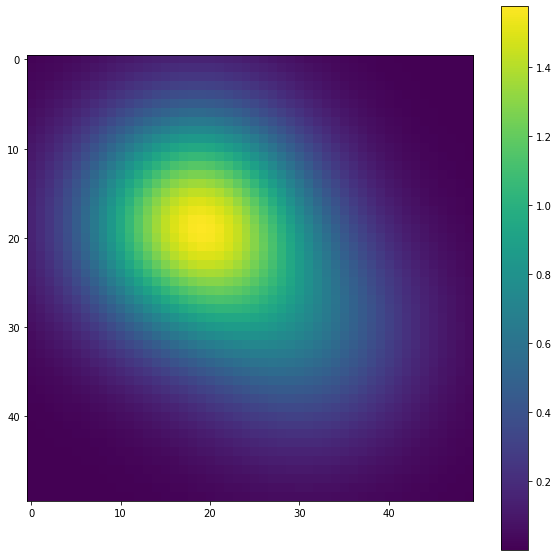

In [8]:
x = np.linspace(-2, 2)
y = np.linspace(-2, 2)
xx, yy = np.meshgrid(x, y)

exp1 = 1.5*np.exp(-((xx+0.5)**2+(yy+0.5)**2))
exp2 = 0.5*np.exp(-((0.5-xx)**2+(0.5-yy)**2))

asymmetric_data = np.expand_dims(exp1 + exp2, axis=0)

plt.figure(figsize=(10,10))
plt.imshow(asymmetric_data[0])
plt.colorbar()

To feed this data into the feature detection we need to convert it into an xarray-DataArray. Before we do that we we select an arbitrary time and date for the single frame of our synthetic field:

In [9]:
date = np.datetime64('2022-04-01T00:00', )
assym = xr.DataArray(data=asymmetric_data, coords={'time':np.expand_dims(date, axis = 0),'y':y, 'x':x})
assym

<xarray.DataArray (time: 1, y: 50, x: 50)>
array([[[0.01666536, 0.02114886, 0.02648334, ..., 0.00083392,
         0.00058509, 0.00040694],
        [0.02114886, 0.02683866, 0.03360844, ..., 0.00109464,
         0.00077154, 0.0005393 ],
        [0.02648334, 0.03360844, 0.04208603, ..., 0.00142435,
         0.00100896, 0.00070907],
        ...,
        [0.00083392, 0.00109464, 0.00142435, ..., 0.01405279,
         0.01121917, 0.00883872],
        [0.00058509, 0.00077154, 0.00100896, ..., 0.01121917,
         0.00895731, 0.00705704],
        [0.00040694, 0.0005393 , 0.00070907, ..., 0.00883872,
         0.00705704, 0.00556009]]])
Coordinates:
  * time     (time) datetime64[ns] 2022-04-01
  * y        (y) float64 -2.0 -1.918 -1.837 -1.755 ... 1.755 1.837 1.918 2.0
  * x        (x) float64 -2.0 -1.918 -1.837 -1.755 ... 1.755 1.837 1.918 2.0

Since we do not have a dt in this dataset, we can not use the get_spacings-utility this time and need to calculate the spacing manually:

In [10]:
dxy = (assym['x'][1] - assym['x'][0])

Finally, we choose a threshold in the datarange and apply the feature detection with the four position_threshold flags
- 'center'
- 'extreme'
- 'weighted_diff'
- 'weighted_diff'

In [11]:
%%capture

threshold = 0.5
features_center = tobac.themes.tobac_v1.feature_detection_multithreshold(assym, dxy, threshold, position_threshold='center')
features_extreme = tobac.themes.tobac_v1.feature_detection_multithreshold(assym, dxy, threshold, position_threshold='extreme')
features_diff = tobac.themes.tobac_v1.feature_detection_multithreshold(assym, dxy, threshold, position_threshold='weighted_diff')
features_abs = tobac.themes.tobac_v1.feature_detection_multithreshold(assym, dxy, threshold, position_threshold='weighted_diff')                       

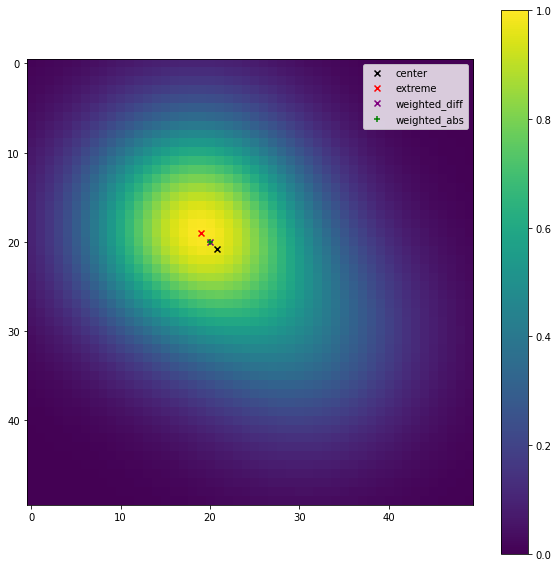

In [12]:
plt.figure(figsize = (10, 10))
plt.imshow(assym[0])
plt.scatter(features_center['hdim_2'], features_center['hdim_1'], color = 'black', marker = 'x', label = 'center')
plt.scatter(features_extreme['hdim_2'], features_extreme['hdim_1'], color = 'red', marker = 'x', label = 'extreme')
plt.scatter(features_diff['hdim_2'], features_diff['hdim_1'], color = 'purple', marker = 'x', label = 'weighted_diff')
plt.scatter(features_abs['hdim_2'], features_abs['hdim_1'], color = 'green', marker = '+', label = 'weighted_abs')
plt.colorbar()
plt.legend()

- extreme: highest value within the area above the threshold
- center : geometrical center of the area above the threshold
- weighted: mixture of both ??? HOw?

## Sigma threshold

Before the features are searched a gausian filter is applied to the data in order to smooth it. So let's import the filter used by tobac for a demonstration:

In [64]:
from scipy.ndimage.filters import gaussian_filter

This filter works performing a convolution of a (in our case 2-dimensional) gaussian function

$$
h(x, y) = \frac{1}{2 \pi \sigma^2} \exp \left( - \frac{x^2+y^2}{2 \sigma^2} \right)
$$

with our data.

The effect of this filter can best be demonstrated on very sharp edges in the input. Therefore we create an array from a boolean mask of another 2d-Gaussian, which only has values of 0 or 1:

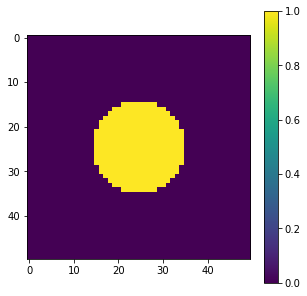

In [13]:
x = np.linspace(-2, 2)
y = np.linspace(-2, 2)
xx, yy = np.meshgrid(x, y)

exp = np.exp(-(xx**2+yy**2))

gaussian_data = np.expand_dims(exp, axis=0)
data_sharp = np.array(gaussian_data > 0.5, dtype = 'float32')

plt.figure(figsize=(5,5))
plt.imshow(data_sharp[0])
plt.colorbar()

If we apply this filter to the data with increasing sigmas, increasingly smoothed data will be the result:

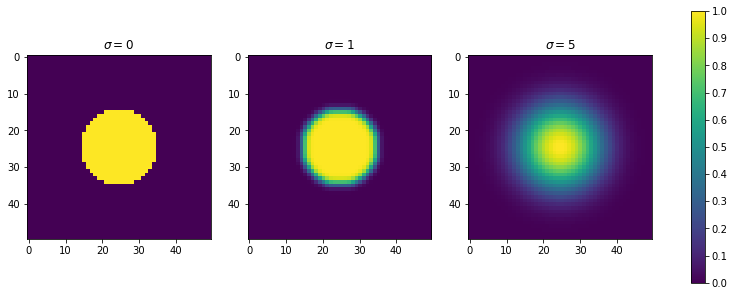

In [14]:
non_smooth_data = gaussian_filter(data_sharp, sigma=0)
smooth_data = gaussian_filter(data_sharp, sigma=1)
smoother_data = gaussian_filter(data_sharp, sigma=5)

fig, axes = plt.subplots(ncols = 3, figsize = (14, 10))

im0 = axes[0].imshow(non_smooth_data[0])
axes[0].set_title(r'$\sigma = 0$')

im1 = axes[1].imshow(smooth_data[0])
axes[1].set_title(r'$\sigma = 1$')

im2 = axes[2].imshow(smoother_data[0])
axes[2].set_title(r'$\sigma = 5$')

cbar = fig.colorbar(im1, ax = axes.tolist(), shrink = 0.5)
cbar.set_ticks(np.linspace(0, 1, 11))

This is what happens in the background, when the *feature_detection_multithreshold()* function is called. The default value of *sigma_threshold* is 0.5. The next step is trying to detect features of the dataset with these *sigma_threshold* values. We first need an xarray DataArray again:

In [68]:
date = np.datetime64('2022-04-01T00:00' )
input_data = xr.DataArray(data=data_sharp, coords={'time':np.expand_dims(date, axis = 0),'y':y, 'x':x})

Now we set a threshold and detect the features:

In [69]:
%%capture

threshold = 0.9
features_sharp = tobac.themes.tobac_v1.feature_detection_multithreshold(input_data, dxy, threshold, sigma_threshold=0)
features_smooth = tobac.themes.tobac_v1.feature_detection_multithreshold(input_data, dxy, threshold, sigma_threshold=1)
features_smoother = tobac.themes.tobac_v1.feature_detection_multithreshold(input_data, dxy, threshold, sigma_threshold=5)

Attempting to plot the results

TypeError: 'NoneType' object is not subscriptable

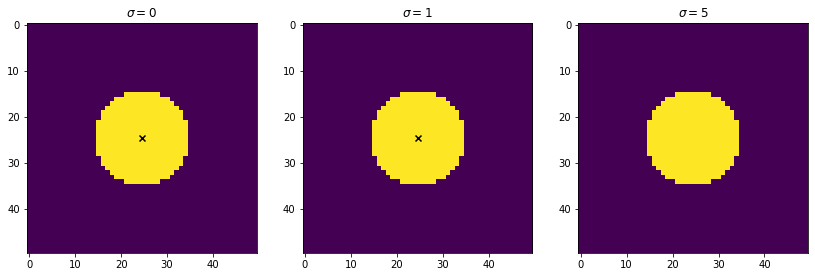

In [70]:
fig, axes = plt.subplots(ncols = 3, figsize = (14, 10))

im0 = axes[0].imshow(input_data[0])
axes[0].set_title(r'$\sigma = 0$')
axes[0].scatter(features_sharp['hdim_2'], features_sharp['hdim_1'], color = 'black', marker = 'x')

im0 = axes[1].imshow(input_data[0])
axes[1].set_title(r'$\sigma = 1$')
axes[1].scatter(features_smooth['hdim_2'], features_smooth['hdim_1'], color = 'black', marker = 'x')

im0 = axes[2].imshow(input_data[0])
axes[2].set_title(r'$\sigma = 5$')
axes[2].scatter(features_smoother['hdim_2'], features_smoother['hdim_1'], color = 'black', marker = 'x')


stops with an error for the last value of sigma, since no features where detected there. The reason for this is that the data has been smoothed to such an extent that no value exceeds the threshold value any more, which can be verified by checking the maximum of our previously filtered array:

In [19]:
smoother_data[0].max()

0.87697566

In this way we can for example remove noise from the data by finetuning this parameter.

## n_erosion_threshold

To understand this parameter we have to look at one varibale of the feature-Datasets we did not mention so far: *num*

The value of *num* for a specific feature tells us the number of datapoints of the feature exceeding the threshold.

In [27]:
%%capture
threshold = 0.5
features = tobac.themes.tobac_v1.feature_detection_multithreshold(input_data, dxy, threshold, n_erosion_threshold=0)

In [28]:
features['num'].data[0]

332

In [29]:
mask = data_sharp > threshold
mask.sum()

332

In [30]:
features_eroded = tobac.themes.tobac_v1.feature_detection_multithreshold(input_data, dxy, threshold, n_erosion_threshold=2)
features_eroded

   frame  idx  hdim_1  hdim_2  num  threshold_value  feature  \
0      0    1    25.0    25.0  293              0.5        1   

                  time              timestr         y         x  
0  2022-04-01 00:00:00  2022-04-01 00:00:00  0.040816  0.040816  
['time', 'y', 'x']


<xarray.Dataset>
Dimensions:          (index: 1)
Coordinates:
  * index            (index) int64 0
Data variables:
    frame            (index) int64 0
    idx              (index) int64 1
    hdim_1           (index) float64 25.0
    hdim_2           (index) float64 25.0
    num              (index) int64 293
    threshold_value  (index) float64 0.5
    feature          (index) int64 1
    time             (index) object 2022-04-01 00:00:00
    timestr          (index) object '2022-04-01 00:00:00'
    y                (index) float64 0.04082
    x                (index) float64 0.04082

Text(0.5, 1.0, '$n = 5$')

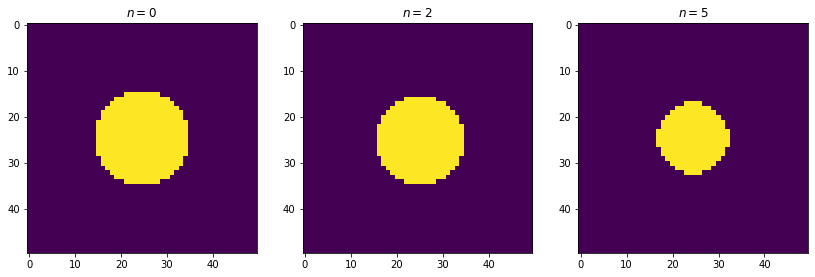

In [31]:
from skimage.morphology import binary_erosion

mask = gaussian_data > threshold
mask = mask[0]

fig, axes = plt.subplots(ncols = 3, figsize = (14, 10))

im0 = axes[0].imshow(mask)
axes[0].set_title(r'$n= 0$')

n_erosion_threshold = 2
selem = np.ones((n_erosion_threshold, n_erosion_threshold))
mask_er = binary_erosion(mask, selem).astype(np.int64)

im1 = axes[1].imshow(mask_er)
axes[1].set_title(r'$n = 2$')

n_erosion_threshold = 5
selem = np.ones((n_erosion_threshold, n_erosion_threshold))
mask_er_more = binary_erosion(mask, selem).astype(np.int64)

im2 = axes[2].imshow(mask_er_more)
axes[2].set_title(r'$n = 5$')

## n_min_threshold

With *n_min_threshold* parameter we can exclude smaller features by setting a minimum of datapoints that have to exceed the threshold for one feature. If we again detect the single feature of our gaussian data and check its num value, we can see that it contains 332 pixels:

In [90]:
%%capture

threshold = 0.5
features = tobac.themes.tobac_v1.feature_detection_multithreshold(input_data, dxy, threshold)

In [91]:
features['num'].data

array([332])

If we now use an *n_min-threshold* above or equal this value, we will detect no features:

In [92]:
features = tobac.themes.tobac_v1.feature_detection_multithreshold(input_data, dxy, threshold, n_min_threshold=332)

In [93]:
print(features)

None


## min_distance

In [122]:
%%capture

data = tobac.testing.make_sample_data_2D_3blobs()

thresholds = [9]
dxy, dt = tobac.utils.get_spacings(data)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, thresholds, min_distance=0)

n = 50

mask = features['frame'] == n

In [127]:
features.where(mask).dropna(dim = 'index')

<xarray.Dataset>
Dimensions:                  (index: 3)
Coordinates:
  * index                    (index) int64 60 61 62
Data variables: (12/13)
    frame                    (index) float64 50.0 50.0 50.0
    idx                      (index) float64 1.0 2.0 3.0
    hdim_1                   (index) float64 17.15 52.0 110.0
    hdim_2                   (index) float64 28.72 97.73 70.0
    num                      (index) float64 501.0 30.0 325.0
    threshold_value          (index) float64 9.0 9.0 9.0
    ...                       ...
    time                     (index) object 2000-01-01 12:50:00 ... 2000-01-0...
    timestr                  (index) object '2000-01-01 12:50:00' ... '2000-0...
    projection_y_coordinate  (index) float64 1.715e+04 5.2e+04 1.1e+05
    projection_x_coordinate  (index) float64 2.872e+04 9.773e+04 7e+04
    latitude                 (index) object 24.29 24.98 24.7
    longitude                (index) object 150.2 150.5 151.1

In [164]:
feature_1 = features.where(features['feature'] == 61.0).dropna('index')
feature_2 = features.where(features['feature'] == 62.0).dropna('index')
feature_3 = features.where(features['feature'] == 63.0).dropna('index')

In [171]:
features.where(features[''])dropna('index')

<xarray.Dataset>
Dimensions:                  (index: 102)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 6 ... 96 97 98 99 100 101
Data variables: (12/13)
    frame                    (index) int64 0 1 2 3 4 5 6 ... 67 67 68 68 69 69
    idx                      (index) int64 1 1 1 1 1 1 1 1 1 ... 1 2 1 2 1 2 1 2
    hdim_1                   (index) float64 10.0 10.94 11.71 ... 30.92 132.7
    hdim_2                   (index) float64 10.0 11.85 13.66 ... 90.79 93.52
    num                      (index) int64 69 66 65 65 65 ... 495 278 412 229
    threshold_value          (index) int64 9 9 9 9 9 9 9 9 9 ... 9 9 9 9 9 9 9 9
    ...                       ...
    time                     (index) object 2000-01-01 12:00:00 ... 2000-01-0...
    timestr                  (index) object '2000-01-01 12:00:00' ... '2000-0...
    projection_y_coordinate  (index) float64 1e+04 1.094e+04 ... 1.327e+05
    projection_x_coordinate  (index) float64 1e+04 1.185e+04 ... 9.352e+04
    latitude                 (index) object 24.1 24.12 24.14 ... 24.91 24.94
    longitude                (index) object 150.1 150.1 150.1 ... 150.3 151.3

In [161]:
tobac.analysis.analysis.calculate_distance(feature_1, feature_2, method_distance='xy')

index
0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
97    NaN
98    NaN
99    NaN
100   NaN
101   NaN
Length: 102, dtype: float64

In [147]:
np.sqrt((feature_1["projection_x_coordinate"]- feature_2["projection_x_coordinate"])** 2
            +(feature_1["projection_y_coordinate"]-feature_2["projection_y_coordinate"])** 2)

<xarray.DataArray (index: 0)>
array([], dtype=float64)
Coordinates:
  * index    (index) int64

In [155]:
np.sqrt((feature_1["projection_x_coordinate"].data-feature_2["projection_x_coordinate"].data)**2 + 
    (feature_1["projection_y_coordinate"].data-feature_2["projection_y_coordinate"].data)**2 )

array([77307.67873611])

In [95]:
%%capture

data = tobac.testing.make_sample_data_2D_3blobs()

thresholds = [10]
dxy, dt = tobac.utils.get_spacings(data)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, thresholds, min_distance=1e5)

n = 50

mask = features['frame'] == n

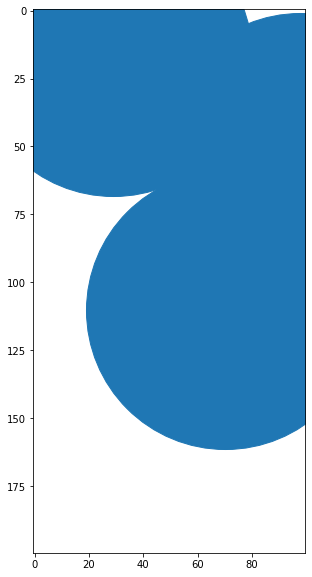

In [157]:
fig, ax1 = plt.subplots(ncols = 1, figsize = (10, 10))
ax1.imshow(data.data[50], cmap = 'Greys')
#ax1.plot(features.where(mask)['hdim_2'], features.where(mask)['hdim_1'], marker = 'x', linestyle = '', color = 'green')
im1 = ax1.scatter(features.where(mask)['hdim_2'], features.where(mask)['hdim_1'], s = 77307)

In [63]:
data

<xarray.DataArray 'w' (time: 100, y: 200, x: 100)>
[2000000 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-01-01T13:39:00
  * y          (y) float64 0.0 1e+03 2e+03 3e+03 ... 1.97e+05 1.98e+05 1.99e+05
  * x          (x) float64 0.0 1e+03 2e+03 3e+03 ... 9.7e+04 9.8e+04 9.9e+04
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
Attributes:
    units:    m s-1

In [86]:
features.where(mask)['hdim_2']

<xarray.DataArray 'hdim_2' (index: 50)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
       28.66820276, 70.        ,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan])
Coordinates:
  * index    (index) int64 0 0 0 0 0 0 0 0 0 0 0 1 0 ... 0 1 0 1 0 1 0 1 0 1 0 1

## wavelength_filtering

| **Parameter** | done |
| threshold     | yes  |
    min_num=0
    target="maximum"
    position_threshold="center",
    sigma_threshold=0.5
    n_erosion_threshold=0
    n_min_threshold=0
    min_distance=0
    feature_number_start=1
    wavelength_filtering=None

In [ ]:
axes